# Density estimation ussing GMM

This is an example of techniques for density estimation ussing mixtures of Gaussians. The example uses Python classes from Scikit-learn.

In [1]:
%matplotlib inline
%precision 2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GMM
from sklearn.mixture import DPGMM
from sklearn.mixture import VBGMM

import scipy
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10,4)
colors = ['blue', 'red']
np.random.seed(42)


print(("Using the following versions\n"
       "Numpy : {}\n"
       "Scikit-learn : {}\n"
       "Matplotlib : {}\n"
       "Scipy : {}\n"
       ).format(np.__version__, sklearn.__version__,
                matplotlib.__version__, scipy.__version__))

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using the following versions
Numpy : 1.11.1
Scikit-learn : 0.18.dev0
Matplotlib : 1.5.1
Scipy : 0.17.0



In [2]:
from scipy.stats import multivariate_normal

class GaussianMixtureModel(object):
    """ One dimensional Gaussian Mixture Model
        
        Parameters:
            means [array<float>] :        Mean for each Gaussian
            covs [array<float>] :         Variance for each Gaussian
            weights [array<float>] :      Responsability of each Gaussian. Need to sum to one. 
                                          If not they are linearly reescaled.
            n_components [int] :          Number of Gaussians
    """
    def __init__(self, n_components=None, params=None):
        self.parameters_set = False
        if params is not None:
            (means, covs, weights) = zip(*params)
            self.means = np.array(means)
            self.covs = np.array(covs)
            self.weights = np.array(weights)
            self.weights = np.true_divide(self.weights, self.weights.sum())
            self.n_components = len(self.means)
            self.parameters_set = True
        elif n_components is not None:
            self.n_components = n_components
        
        
    def expectation_maximization(self, X, max_steps=100):
        if not self.parameters_set:
            self.init_parameters(X)
            
        log_likelihood = self.log_likelihood(X)
        step = 0
        converged = False
        while not converged and step != max_steps:
            # Expectation step
            responsibilities = self.compute_responsibilities(X)
            # Maximization step
            self.estimate_parameters(X, responsibilities)
            # Evaluation
            new_log_likelihood = self.log_likelihood(X)
            converged = np.abs(new_log_likelihood - log_likelihood) < 0.01
            log_likelihood = new_log_likelihood
            step += 1
            
    def compute_responsibilities(self, X):
        X = X.flatten()
        result = np.zeros((len(X), self.n_components))
        for i, (mean, cov, w) in enumerate(zip(self.means, self.covs, self.weights)):
            result[:,i] = w*self.normal_distribution(X,mean,cov)
            
        return np.true_divide(result, result.sum(axis=1).reshape(-1,1))
    
    def estimate_parameters(self, X, responsibilities):
        nk = responsibilities.sum(axis=0)
        n = nk.sum()
        assert np.abs(n-len(X)) <= 0.0001, "N and float(len(X)) are not equal: [{} != {}]".format(n, float(len(X)))
        self.estimate_weights(n, nk)
        self.estimate_means(X, nk, responsibilities)
        self.estimate_covs(X, nk, responsibilities)
        
    def estimate_means(self, X, nk, responsibilities):
        self.means = (responsibilities*X).sum(axis=0)/nk
        
    def estimate_covs(self, X, nk, ws):
        self.covs = (ws*((X-self.means)**2)).sum(axis=0)/nk
        #for i in range(len(self.covs)):
        #    self.covs[i] = (ws[:,i]*((X-self.means[i])**2)).sum()/nk[i]
        
        # This one works
        #for i in range(len(self.covs)):
        #    distance = X-self.means[i]
        #    self.covs[i] = np.dot(ws[:,i], distance**2)
        #self.covs /= nk
        
    def estimate_weights(self, n, nk):
        self.weights = nk/n
        
        
    def log_likelihood(self, X):
        X = X.flatten()
        result = np.zeros((len(X), self.n_components))
        for i, (mean, cov, w) in enumerate(zip(self.means, self.covs, self.weights)):
            result[:,i] = w*self.normal_distribution(X,mean,cov)
        return np.log(result.sum(axis=1)).sum()
        
    def normal_distribution(self, X, mean, cov):
        return multivariate_normal.pdf(X, mean, cov)
        #return np.true_divide(np.exp(-0.5*(((X-mean)**2)/cov)), np.sqrt(2*cov*np.pi))
        
    def init_parameters(self, X):
        self.init_means(X)
        self.init_covariances(X)
        self.init_weights()
        self.parameters_set = True
    
    def init_means(self, X):
        self.means = np.random.rand(self.n_components)*(X.max()-X.min())*0.9+X.min()
        
    def init_covariances(self, X):
        self.covs = np.ones(self.n_components)*(X.max()-X.min())/(4*self.n_components)
        
    def init_weights(self):
        self.weights = np.ones(self.n_components)/self.n_components
        
    def set_means(self, means):
        self.means = means
    
    def set_covariances(self, covs):
        self.covs = covs
        
    def set_weights(self, weights):
        self.weights = weights
            
    def pdfs(self, x):
        if not self.parameters_set:
            self.init_parameters(x)
        x = x.flatten()
        results = np.zeros((len(x), self.n_components))
        for i, (mean, cov, w) in enumerate(zip(self.means, self.covs, self.weights)):
            results[:,i] =  w*self.normal_distribution(x,mean,cov)
        return results
        
    def pdf(self, x):
        if not self.parameters_set:
            self.init_parameters(x)
        results = self.pdfs(x)
        return results.sum(axis=1)
    
    def sample(self, N, return_label=False):
        if not self.parameters_set:
            raise Exception('Not possible to generate samples: the parameters are not set')
        samples = []
        y = []
        
        # Compute how many samples per gaussian are needed
        num_samples = np.round(N*self.weights)
        # Correct for inprecision in order to sum to N
        num_samples[np.argmax(num_samples)] += N-num_samples.sum()
        
        for i, (mean, cov, n) in enumerate(zip(self.means, self.covs, num_samples)):
            samples.append(np.random.normal(mean, np.sqrt(cov), n))
            y.append(np.ones(n)*(i+1))
        
        samples = np.concatenate(samples).flatten()
        y = np.concatenate(y).flatten()
        
        indices = np.random.shuffle(range(N))
        samples = samples[indices].reshape(-1,1)
        
        if return_label == True:
            y = y[indices].reshape(-1,1)
            return samples, y
        else:
            return samples

## Dataset: toy example

Given a dataset of independent and identically distributed observations $X = \{x_1, \dots, x_N\}$ comming from a mixture of $K$ Gaussians with unknown set of parameter values $\Theta = \{\theta_1, \dots, \theta_K\}$ where $\theta_i = \{\mu_i, \sigma_i\}$ and the latent variable $Z = \{z_1, \dots, z_N\}$ where $z_n \in \{1,\dots,K\}$ denoting which Gaussian has generated the observation $x_n$.

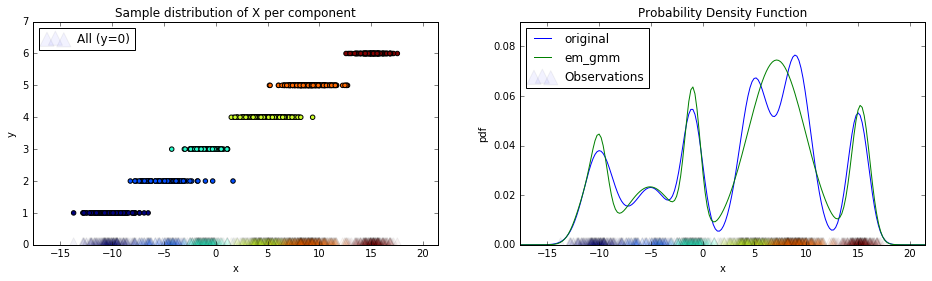

In [3]:
# Hidden or latent variables
N = 1000
Z = {1: (-10.0, 2.0, 200),
     2: (-5.0, 3.0, 150),
     3: (-1.0, 1.0, 200),
     4: (5.0, 2.0, 350),
     5: (9.0, 2.0, 400),
     6: (15.0, 1.0, 200)}

# Compute the original pdf
original_gmm = GaussianMixtureModel(params=Z.values())
X, Y = original_gmm.sample(N, return_label=True)

# A grid for the following density estimations
x_grid = np.linspace(X.min()-X.std()*0.5, X.max()+X.std()*0.5, 200).reshape(-1,1)

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax1.set_title('Sample distribution of X per component')
ax1.scatter(X, Y, c=Y)
ax1.scatter(X, np.zeros_like(X), marker='^', c=Y, s=200, label='All (y=0)', alpha=0.05)
ax1.set_ylim([0,len(Z)+1])
ax1.set_xlim([x_grid.min(), x_grid.max()])
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.legend(loc='upper left')

em_gmm = GaussianMixtureModel(n_components=len(Z))
em_gmm.expectation_maximization(X)

ax2 = fig.add_subplot(122)
ax2.set_title('Probability Density Function')
ax2.plot(x_grid, original_gmm.pdf(x_grid), label='original')
ax2.plot(x_grid, em_gmm.pdf(x_grid), label='em_gmm')
ax2.scatter(X, np.zeros_like(X), marker='^', c=Y, s=200, label='Observations', alpha=0.05)
ax2.set_ylim(0)
ax2.set_xlim([x_grid.min(), x_grid.max()])
ax2.set_ylabel('pdf')
ax2.set_xlabel('x')
ax2.legend(loc='upper left')

## Modeling the data

We want to model the previous distribution with a mixture of Gaussians. In this example we will assume that we know the original number of Gaussians $K$.

We want to find the set of parameter values $\Theta$ and the mixing coefficients $\pi = \{\pi_1, \dots, \pi_K\}$ that maximize the likelihood function

$$
p(X|\mu, \Sigma, \pi) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(x_n|\mu_k, \Sigma_k)
$$

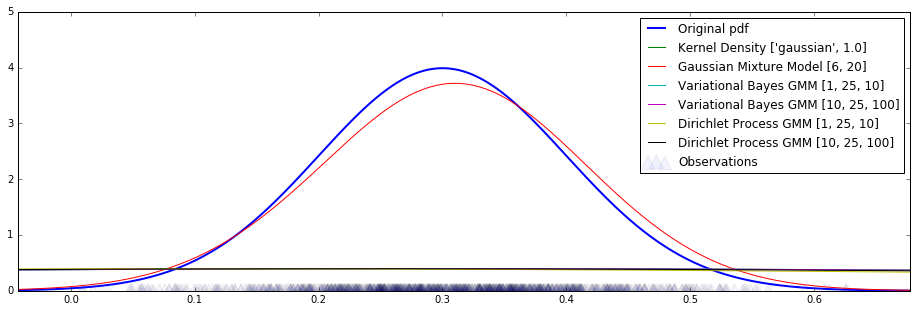

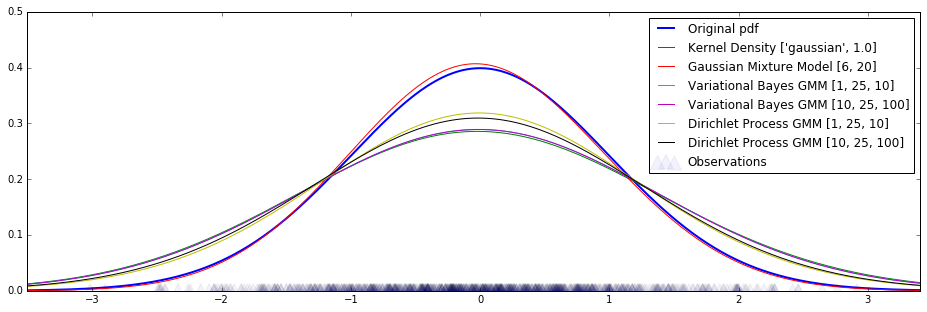

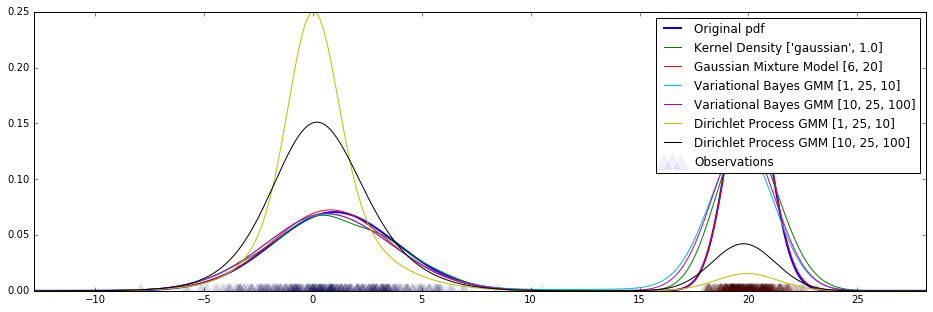

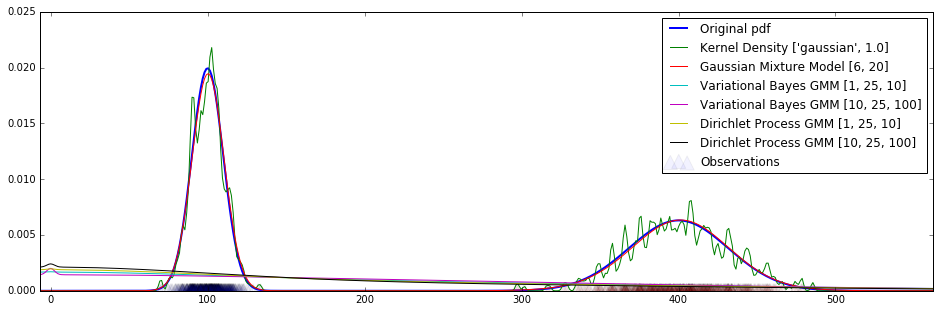

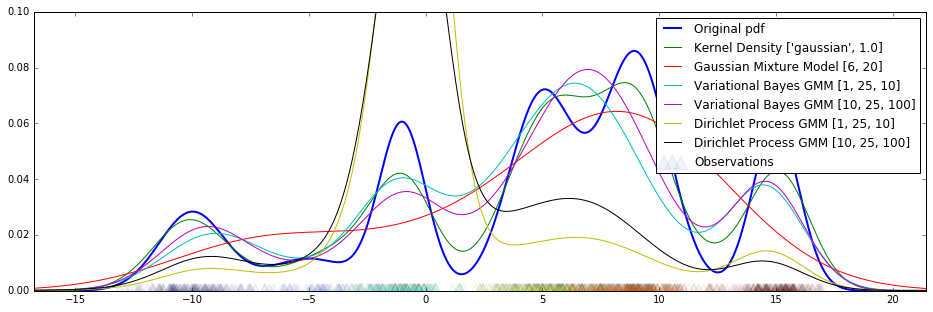

In [4]:
models = [(KernelDensity, {'kernel':'gaussian', 'bandwidth':1.0},"Kernel Density"),
          (GMM, {'n_components':6, 'n_init':20},"Gaussian Mixture Model"),
          
          (VBGMM, {'n_components':25, 'alpha':1, 'n_iter':10},"Variational Bayes GMM"),
          (VBGMM, {'n_components':25, 'alpha':10, 'n_iter':100},"Variational Bayes GMM"),
          (DPGMM, {'n_components':25, 'alpha':1, 'n_iter':10},"Dirichlet Process GMM"),
          (DPGMM, {'n_components':25, 'alpha':10, 'n_iter':100},"Dirichlet Process GMM")]


N = 1000
Z = ({1: (0.3,0.01,1)},
     
     {1: (0,1,1)},
     
     {1: (1, 8, 0.5),
      2: (20, 1, 0.5)},
     
     {1: (100, 100, 0.5),
      2: (400, 1000, 0.5)},
     
     {1: (-10.0, 2.0, 0.1),
      2: (-5.0, 3.0, 0.05),
      3: (-1.0, 1.0, 0.15),
      4: (5.0, 2.0, 0.25),
      5: (9.0, 2.0, 0.3),
      6: (15.0, 1.0, 0.15)},
     )


for z in Z:
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(111)
    
    # Compute the original pdf
    original_gmm = GaussianMixtureModel(params=z.values())
    X, Y = original_gmm.sample(N, return_label=True)

    # A grid for the following density estimations
    x_grid = np.linspace(X.min()-X.std()*0.5, X.max()+X.std()*0.5, 500).reshape(-1,1)

    ax.plot(x_grid, original_gmm.pdf(x_grid), lw=2, label='Original pdf')
    ax.scatter(X, np.zeros_like(X), marker='^', c=Y, s=200, label='Observations', alpha=0.05)
    ax.set_ylim(0)
    ax.set_xlim([x_grid.min(), x_grid.max()])
    for i, (model, args, name) in enumerate(models):
        d_estimator = model(**args)

        d_estimator.fit(X)

        if model in [KernelDensity]:
            q_x = np.exp(d_estimator.score_samples(x_grid))
        elif model in [DPGMM, VBGMM, GMM]:
            parameters = zip(d_estimator.means_.flatten(), 
                             np.concatenate(d_estimator._get_covars()).flatten(), 
                             d_estimator.weights_)
            de_copy = GaussianMixtureModel(params=parameters)
            q_x = de_copy.pdf(x_grid)
        else:
            q_x = np.exp(d_estimator.score(x_grid))

        ax.plot(x_grid, q_x, label="{} {}".format(name, args.values()))

    ax.legend(loc='upper right')